In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import itertools

# Read Data

In [5]:
data = pd.read_csv("C:\\Users\\tgmce\\Downloads\\Bank Customer Churn Prediction_revised.csv")
x = data.iloc[:, :-1]
y = data.iloc[:, -1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30,random_state = 0)

# Build Model

In [6]:
model=sm.Logit(y_train, sm.add_constant(x_train))
lr = model.fit()
print(lr.summary())

Optimization terminated successfully.
         Current function value: 0.435680
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6990
Method:                           MLE   Df Model:                            9
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                  0.1348
Time:                        02:03:48   Log-Likelihood:                -3049.8
converged:                       True   LL-Null:                       -3524.9
Covariance Type:            nonrobust   LLR p-value:                9.177e-199
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1303      0.288    -10.869      0.000      -3.695      -2.566
credit_scor

# Make Prediction on Training and Testing Sample

In [7]:
p_pred_train = lr.predict(sm.add_constant(x_train))
p_pred_test = lr.predict(sm.add_constant(x_test))

# ROC Curve for Testing Sample

AUC for training sample is: 0.7519720640490182


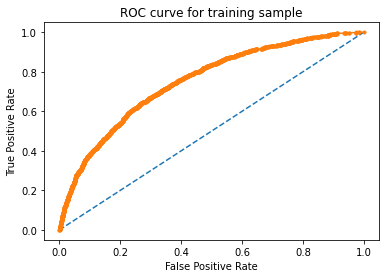

In [8]:
mr_probs = [0 for _ in range(len(y_train))]
mr_fpr, mr_tpr, _ = roc_curve(y_train, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, p_pred_train)
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for training sample')
print('AUC for training sample is:', metrics.auc(lr_fpr, lr_tpr))

# Report Confusion Matrix

In [9]:
from sklearn.metrics import confusion_matrix
y_pred = round(p_pred_test)
print('Confusion matrix is:', confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('MR:', (fp+fn)/(tn+fp+fn+tp))
print('TPR:', tp/(tp+fn))
print('FNR:', fn/(tp+fn))

Confusion matrix is: [[2305   74]
 [ 517  104]]
MR: 0.197
TPR: 0.16747181964573268
FNR: 0.8325281803542673


# Conduct Backwards Stepwise Selection

Optimization terminated successfully.
         Current function value: 0.435680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436206
  

Text(0, 0.5, 'aic')

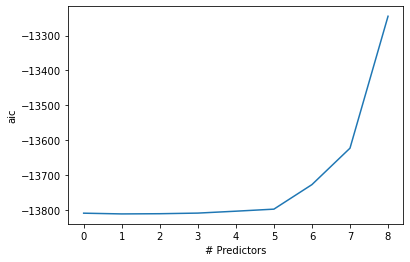

In [13]:
def fit_lr(feature_set):
    model = sm.Logit(y_train, sm.add_constant(x_train[list(feature_set)]))
    lr = model.fit()
    MSE = mean_squared_error(lr.predict(sm.add_constant(x_train[list(feature_set)])),y_train)
    AIC = len(x_train)*np.log(MSE)+2*len(lr.params)
    return {"model":lr, "MSE":MSE, "AIC":AIC}

def getbest(k):
    result = []
    for combo in itertools.combinations(x_train.columns, k):
        result.append(fit_lr(combo))
    models = pd.DataFrame(result)
    best_model = models.loc[models['MSE'].argmin()]
    return best_model

picked = list(x_train.columns)
models_best = pd.DataFrame(columns=["model","MSE","AIC"])
models_best.loc[0] = fit_lr(picked)
for i in range(1,9):
    best_MSE = np.inf
    for combo in itertools.combinations(picked,len(picked)-1):
        MSE = fit_lr(list(combo))["MSE"]
        if MSE < best_MSE:
            best_MSE = MSE
            best_feature = combo
    picked = best_feature
    models_best.loc[i] = fit_lr(list(picked))
print(models_best)
plt.plot(models_best["AIC"])
plt.xlabel('# Predictors')
plt.ylabel('aic')

# Return Best Model

In [14]:
print(models_best.loc[1, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6991
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                  0.1348
Time:                        02:05:54   Log-Likelihood:                -3049.8
converged:                       True   LL-Null:                       -3524.9
Covariance Type:            nonrobust   LLR p-value:                8.441e-200
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1437      0.284    -11.087      0.000      -3.699      -2.588
credit_score        -0.0009      0.000     -2.712      0.007      -0.002      -0.000
gender              -0.5390 

# Obtain AUC

In [16]:
lr_backward = models_best.loc[1, "model"]
p_pred_test = lr_backward.predict(sm.add_constant(x_test[['credit_score','gender','age','tenure','balance','products_number','active_member','estimated_salary']]))
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, p_pred_test)
print('AUC for testing sample is:', metrics.auc(lr_fpr, lr_tpr))

AUC for testing sample is: 0.7648574246340937
